In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm
import os
from PIL import Image
from tqdm import tqdm
import pandas as pd


/home/chep_workstation/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chep_workstation/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/chep_workstation/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        
        # First 1x1 convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Last 1x1 convolution
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential()
        
        # Adjust the residual connection when needed
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        
        identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x

    
def save_network(network, epoch_label):
    save_filename = 'net_%s.pth' % epoch_label
    base_path = "./network_resnet"
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    file_save_path = os.path.join(base_path, save_filename)    
    torch.save(network.state_dict(), file_save_path)
        

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=2).to(device)
print('Total Parameters:', sum([p.nelement() for p in model.parameters()]) )
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")
    
    model.eval()
    total_valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, target)
            total_valid_loss += loss.item()

            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    avg_valid_loss = total_valid_loss / len(val_loader)
    val_losses.append(avg_valid_loss)
    save_network(model, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_valid_loss:.4f}, Accuracy: {100. * correct / total:.2f}%")

print("Training and Evaluation Complete!")
save_path = os.path.join("./network_resnet", "val_losses.csv")
df_val_losses = pd.DataFrame(val_losses)
df_val_losses.to_csv(save_path,header=False)
    

Total Parameters: 23538690
Epoch [1/10], Training Loss: 0.5368
Epoch [1/10], Validation Loss: 0.3071, Accuracy: 87.20%
Epoch [2/10], Training Loss: 0.2701
Epoch [2/10], Validation Loss: 0.3668, Accuracy: 84.90%
Epoch [3/10], Training Loss: 0.1562
Epoch [3/10], Validation Loss: 0.1161, Accuracy: 96.17%
Epoch [4/10], Training Loss: 0.1563
Epoch [4/10], Validation Loss: 0.5043, Accuracy: 82.75%
Epoch [5/10], Training Loss: 0.1805
Epoch [5/10], Validation Loss: 1.8338, Accuracy: 81.90%
Epoch [6/10], Training Loss: 0.1905
Epoch [6/10], Validation Loss: 0.2600, Accuracy: 88.22%
Epoch [7/10], Training Loss: 0.1169
Epoch [7/10], Validation Loss: 0.1041, Accuracy: 96.12%
Epoch [8/10], Training Loss: 0.0690
Epoch [8/10], Validation Loss: 0.1233, Accuracy: 96.72%
Epoch [9/10], Training Loss: 0.0756
Epoch [9/10], Validation Loss: 0.1350, Accuracy: 94.58%
Epoch [10/10], Training Loss: 0.0534
Epoch [10/10], Validation Loss: 0.1360, Accuracy: 96.08%
Training and Evaluation Complete!


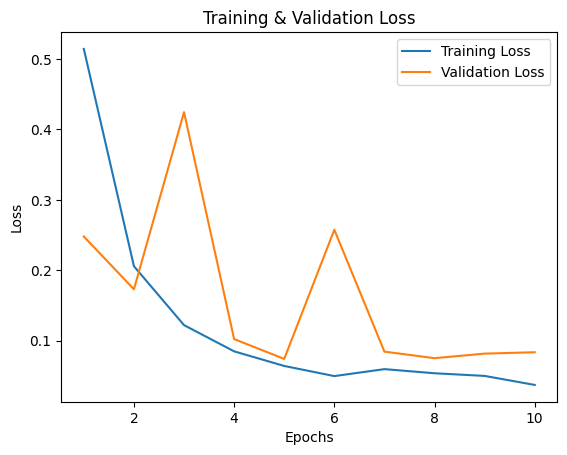

In [290]:

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, '-', label='Training Loss')
plt.plot(epochs, val_losses, '-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


In [291]:
from sklearn.metrics import roc_curve, auc

df_val_losses = pd.read_csv("./network_resnet/val_losses.csv", names=["epoch","val_loss"])
epoch_min = np.array(df_val_losses.loc[df_val_losses.val_loss==df_val_losses.val_loss.min(),"epoch"])[0]
print(str(int(epoch_min)))
state_dict = torch.load("./network_resnet/net_"+str(int(epoch_min))+".pth")
model.load_state_dict(state_dict)
model.to(device)
    
model.eval()
true_labels = []
scores = []

with torch.no_grad():
    for data, target in DataLoader(test_dataset, batch_size=1):
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        
        softmax_scores = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
        scores.extend(softmax_scores.cpu().numpy())
        true_labels.extend(target.cpu().numpy())
        
stacked_array = np.dstack([true_labels, scores])[0]



4


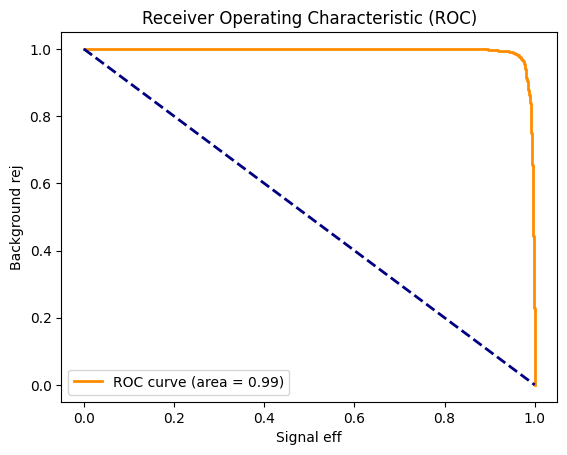

In [292]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(tpr, 1-fpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.xlabel('Signal eff')
plt.ylabel('Background rej')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()

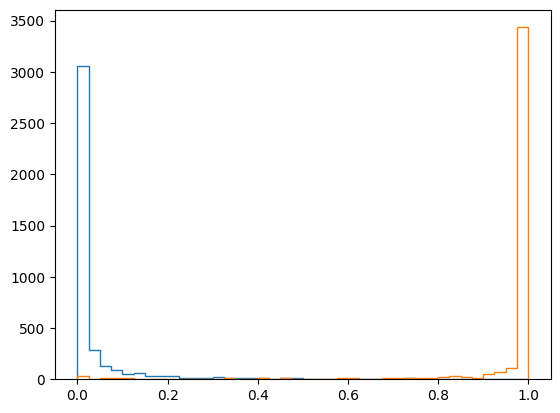

In [295]:
#plt.yscale('log')
plt.hist(stacked_array[stacked_array[:,0]==0,1], histtype='step',
        range=(0,1),bins=40)
plt.hist(stacked_array[stacked_array[:,0]==1,1],histtype='step',
        range=(0,1),bins=40)
plt.show()

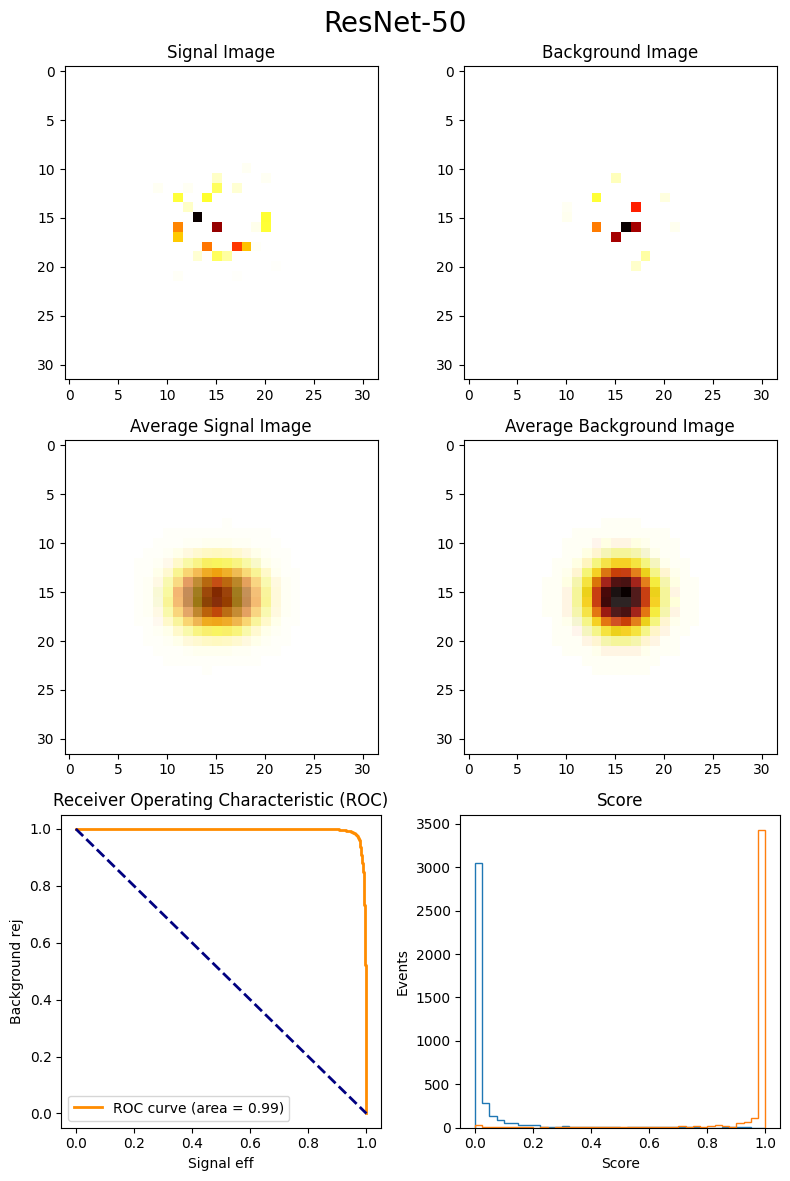

In [317]:
# Plot the averages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
fig.suptitle('ResNet-50', fontsize=20)
sig_img = mpimg.imread('./data_resnet/signal/0.png')
back_img = mpimg.imread('./data_resnet/background/0.png')

axes[0][0].imshow(sig_img)
axes[0][1].imshow(back_img)
axes[1][0].imshow(avg_signal_image)
axes[1][1].imshow(avg_background_image)

axes[0][0].set_title('Signal Image')
axes[0][1].set_title('Background Image')

axes[1][0].set_title('Average Signal Image')
axes[1][1].set_title('Average Background Image')

lw = 2
axes[2][0].plot(tpr, 1-fpr, color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
axes[2][0].plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
axes[2][0].set_xlabel('Signal eff')
axes[2][0].set_ylabel('Background rej')
axes[2][0].set_title('Receiver Operating Characteristic (ROC)')
axes[2][0].legend()

axes[2][1].hist(stacked_array[stacked_array[:,0]==0,1], histtype='step',
        range=(0,1),bins=40)
axes[2][1].hist(stacked_array[stacked_array[:,0]==1,1],histtype='step',
        range=(0,1),bins=40)
axes[2][1].set_xlabel('Score')
axes[2][1].set_ylabel('Events')
axes[2][1].set_title("Score")

#axes[0].set_title('Average Signal Image')
#axes[0].axis('off')

#axes[1].imshow(avg_background_image)
#axes[1].set_title('Average Background Image')
#axes[1].axis('off')

plt.tight_layout()
fig.savefig(f"resnet-50.png", dpi=500, facecolor='w', edgecolor='w',
                orientation='portrait', bbox_inches='tight', pad_inches=0.05)
plt.show()
